# Chapter 14
# Convolutional Neural Networks

## Understanding the Visual Cortex

David H. Huble and Torsten Wiesel showed, in 1981, that many neurons in the visual cortex have a small *local receptive field*, meaning they only react to visual stimuli in a limited region of the visual field. They also showed that some neuros react only to images of horizontal lines, while others reacted to images of line with different orientations. Furthermore, some neurons have larger receptive fields and react to more complex patterns that are combinations of the lower level patterns. (see fig. 14.1 page 447) 

These discoveries inspired the [neocognitron](https://homl.info/74) which evolved into **convolutional neural networks**. A major mileston came with the [1998 paper by Yann LeCunn](https://homl.info/75) which introduced the *LeNet-5* architecture, with convolutional layers and pooling layers.

## Convolutional Layers

A *convolutional layer* tries to mimic the way neurons have a local receptive field. Instead of being connected to every single pixel in the input image, they are connected only to pixels in their receptive fields. (fig 14-2 pg 448). In the second convolutional layer, each neuron is only connected to neurons within a small rectangle in the first layer.

This way, the network concentrates on small low-level features in the first hidden layer, then assembles them into larger higher-level features in the next hidden layer and so on. CNNs work so well for image recognition because this hierarchical structure is part of real world imagery

For this architecture, we have to define $f_h$ and $f_w$, the height and width of the receptive fields. This way, a neuron in row $i$, column $j$ is connected to the outputs of the neurons in the previous layer located in rows $i$ to $i+f_h-1$, columns $j$ to $j + f_w -1$ (see fig 14-3 pg 449). In order to maintain the same height and widht as previous layers, it is common to add zeros around the inputs. This is called *zero padding*.

We can also connect a larger input layer to a much smaller layer by spacing out the receptive fields (figure 14-4), reducing computational complexity. The shift from one receptive field to another is called the *stride* ($s_h$ for height, $s_w$ for width). A neuron located in row $i$, column $j$ n the upper layer is connected to outputs of neurons in the previous layer located in rows $i \times s_h$ to $i\times s_h + f_h -1$, columns $j \times s_w$ to $j\times s_w + f_w -1$

### Filters

Neuron's weights can be represented as a small image the size of the receptive field. Figure 14-4 shows two sets of weights called *filters* (or *convolution kernels*). Ther first one is a black square with a vertical white line in the middle (a 7x7 matrix full of zeros except for the central columns which is full of 1s). Neurons using these weights will ignore everything in their receptive fields except for the middle. The second filter is a black square with a horizontal white line in the middle, working the same way.

Figure 14-4 shows the result of feeding an image to both filters. With the horizontal filters, horizontal lines get enhanced while the rest is blurred out. Thus, a layer full of neurons using the same filter outputs a *feature map*, which highlights the areas in an image that activate the filter the most. 

Filters do not have to be defined manually. Instead, during training the convolutional layer will automatically learn the most useful filters for its task, with higher level layers contributing to more complex patterns

### Stacking multiple feature maps

In practice, a convolutional layer has many filters (you decide how many) and outputs one feature map per filter, so it is more accurately represented in 3D (figure 14-6 pg 452). It has one neuron per pixel in each feature map and all neurons within a given feature map share the same parameters (i.e. weights and bias term). Neurons in different feature maps use different parameters. The receptive fields are the same, but extending across all the previous layers feature maps. In summary, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

Specifically, a neuron in row $i$, column $j$ of feature map $k$ in a given convolutional layer $l$ is connected to the outputs of the neurons in the previous layer $l-1$ located in rows $i\times s_h$ to $i\times s_h + f_h -1$ and columns $j\times s_w$ to $j\times s_w + f_w -1$ across all feature maps.

The following equation summarizes the above: it shows how to compute the output of a given neuron in a convolutional layer. 

$$ z_{i,j,k} = b_k + \sum_{u=0}^{f_h-1}\sum_{v=0}^{f_w-1}\sum_{k'=0}^{f_{n'}-1} x_{i', j', k'} \times w_{u,v,k', k} \text{ with } \begin{cases} i'= i\times s_h +u \\ j'= j\times s_w + v \end{cases}$$

Where
* $z_{i,j,k}$ is the output of the neuron located in row $i$, column $j$ in feature map $k$ of convolutional layer $l$
* $s_h, s_w$ are the vertical and horizontal strides
* $f_h, f_w$ are the height and width of the receptive field and $f_{n'}$ is the number of feature maps in the previous layer (layer $l-1$)
* $b_k$ is the bias term for feature map $k$ (in layer $l$). You can think of it as a knob that tweaks the overall brightness of feature map $k$
* $w_{u, v, k', k}$ is the connection weight between any neuron in feature map $k$ of the layer $l$ and its input located at row $u$, column $v$ and feature map $k'$

### Tensorflow Implementation

In TF, each input image is typically represented as a 3D tensor of shape _[height, width, channels]_. A mini batch is a 4D tensor of shape _[mini-batch size, height, width, channels]_. The weights of a convolutional layer are represented as 4d tensor of shape $[f_h, f_w, f_{n'}, f_n]$. The bias are simply represented as a 1D tensor of shape $[f_n]$.

Let's look at an example

In [1]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [3]:
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

<function matplotlib.pyplot.show(*args, **kw)>

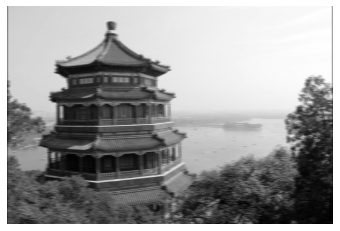

In [4]:
# Create two filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # vertical line

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[0, :, :, 1], cmap='gray') # 1st img, 2nd feature map
plt.axis('off')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

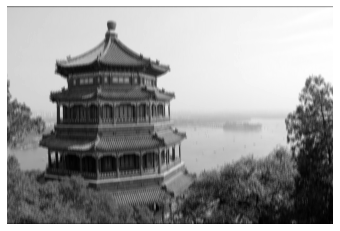

In [5]:
plt.imshow(outputs[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show

```tf.nn.conv2d()``` deserves a bit more detail:
* ```images``` is the input mini batch
* ```filters``` is the set of filters to apply
* ```strides``` is equal to 1
* ```padding``` must be either 'SAME' or 'VALID'
    - SAME means we use zero padding if necessary
    - VALID means we do not use padding and may ignore some rows and columns at the bottom and right of the input image, depending on the stride. Hence every neuron's receptive  field lies strictly within valid positions inside the input and thus, the name

In the example above we manually set the filters, but in reality the filters are trainable variables so the neural net can learn which ones work best. here's an example with a Keras layer

In [6]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')

### Memory Requirements

Due to their architecture, CNNs require a huge amount of RAM, especially during training because of the reverse pass of backpropagation.

Example:

A convolutional layer with $5\times5$ filters, outputting 200 feature maps of size $150\times 100$, with stride 1 and "same" padding. If the input is a $150\times 100$ RGB image (3 channels), then the number of parameters is $(5\times 5\times 3 + 1)\times 200 = 15,200$. 

This is small, when comparered to a fully connected layer. However each of the 200 feature maps contains $150\times 100$ neurons and each of these needs to comput a weighted sum of its $5\times 5 \times 3=75$ inputs, yielding a total of 225 million float multiplications. If the feature maps are represented using 32-bit floats, the convolutional layer's output will occupy $200\times150\times100\times32 = 96$ million bits (12 MB) of RAM. And that's just for one instance, with 100 training instances this layer occupies 1.2 GB or RAM!

*Tip:* If training crashes because of out of memory error, you can try reducing the mini-batch size. You can also try reducing dimensionality using a stride or removing a few layers. You can also try 16-bit floats instead of 32 bits. FInally you can also distribute the CNN across multiple devices!

## Pooling Layers

The goal of pooling layers is to *subsample* the input image (i.e. shrink it) in order to reduce the computational load, memory usage and the number of parameters (thus reducing the risk of overfitting.

Each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. Again, you need to define the size, stride and padding for this layer. The difference, is that pooling layers neurons have no weights, instead, they aggregate the inputs using functions such as max or mean. The most common type  of layer being a *max pooling* layer.

Note: pooling layers work on every input channel independently, so the output depth is the same as the input's depth.

Max pooling layers also bring some level of invariance to small translations (see fig 14-9 pg 458). In addition, max pooling also offers a small amount of rotational invariance and a slight scale invariance. These can be useful in cases where the prediction does not depend on these details, such as classification tasks.

The downside of max pooling layer being that is very destructive. A small 2x2 kernel with stride of 2 causes the output to be two times smaller in both directions, with an area 4 times smaller, simply dropping 75% of the input values.

In addition, in some applications the *invariance* is undesirable. Take for example semantic segmentation (classifying each pixel in an image according to the object that pixel belogs to). If the input image is translated by one pixel to the right, the output should also be translated. The goal in this case is *equivariance*: a small change to the input should correspond to a small change to the output.

You can use Keras' ```MaxPool2D``` layer to implement it. The stride defaults to the kernel size (in the case below, 2). It also uses "valid" padding (i.e. no padding)

In [7]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

Likewise you can use ```AvgPool2D``` for average pooling. Max pooling is more used nowadays as it preserves only the strongest features, getting rid of the meaningless ones and subsequent layers have a cleaner signal to work with. In addition, max pooling offer stronger translation invariance than average pooling and it requires slightly less compute.

Max/avg pooling can also be  performed along the depth dimension rather than the spatial ones, though this is less common. This allows the CNN to be invariant to various features. Fig 14-10 on page 459 illustrates this.

Aother pooling layer you might encounter are *global average pooling* layers. They compute the mean of each feature map, this means they output a single number per feature map per instance. Albeit very destructive, this can be useful as the output layer.

In [8]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

## CNN Architectures

As you can imagine, typical CNN architecture  is composed of a few convolutional layers (followed by a ReLU layer), then a pooling layer, then more convolutional layers (+ReLU), thenm another pooling layer, and so on. This means the image gets smaller and smaller as it progresses through the network but it also gets deeper (i.e. more feature maps). The top of the stack contains a few fully connected layers with the final layer outputting the predictions.

*Tip*: A common  mistake is to use convolutional kernels that are too large (e.g. a 5x5 kernel). As an alternative, using two 3x3 layers will use fewer parametrs and require less computation and usually it performs better. 

One ***exception*** is for the first layer. It can typically have a large kernel with a stride of 2 or more. This reduces the spatial dimensions of the image without losing too much information.

Below is an example of a CNN to tackle Fasion MNIST

In [3]:
X_train_full.shape

(60000, 28, 28)

In [4]:
X_train.shape

(50000, 28, 28, 1)

In [2]:
(X_train_full, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

validation_size = 10000
X_train, y_train = X_train_full[:-validation_size], y_train[:-validation_size]
X_valid, y_valid = X_train_full[-validation_size:], y_train[-validation_size:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [16]:
activation = 'relu'
padding = 'SAME'
conv_args = {'activation': activation, 'padding': padding}

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, input_shape=[28, 28, 1], **conv_args),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, **conv_args),
    keras.layers.Conv2D(128, 3, **conv_args),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, **conv_args),
    keras.layers.Conv2D(256, 3, **conv_args),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=activation),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation=activation),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 256)        

In [17]:
model.fit(X_train, y_train, epochs = 3,
          validation_data=(X_valid, y_valid))

Epoch 1/3
1563/1563 [==============================] - 256s 164ms/step - loss: 0.7295 - accuracy: 0.7444 - val_loss: 18.4215 - val_accuracy: 0.1047
Epoch 2/3
1563/1563 [==============================] - 253s 162ms/step - loss: 0.4395 - accuracy: 0.8548 - val_loss: 16.1881 - val_accuracy: 0.1034
Epoch 3/3
1563/1563 [==============================] - 258s 165ms/step - loss: 0.3670 - accuracy: 0.8784 - val_loss: 19.5470 - val_accuracy: 0.1040


In [ ]:
model.evaluate(X_test, y_test)

Comments on the above:
* The first layer uses a large kernel with stride 1. That is because the images are not very large and only have a single channe;
* The number of filters increase as we climb up the CNN. This happens for two reasons: First, there are a small number of low level features (circles, squares, etc..) but there are many ways of combining them in higher level features. Secondly, it is common practice to double the number of filters after each pooling layer since each pooling layer divides each spatial dimension by a factor of 2
* We add dropout layers to reduce overfitting

Somehow we got 90% accuracy on the test set, yet the validation accuracy was only 10%... not exactly sure why

Over the years there were many variants of this fundamental architecture developed. We will study some of them below

### [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

Probaly the most widely know architecture. It was created to solve Digits MNIST and is composed as follows

| Layer | Type            | Maps | Size    | Kernel size | Stride | Activation |
|-------|-----------------|------|---------|-------------|--------|------------|
| Out   | Fully connected | –    | 10      | –           | –      | RBF        |
| F6    | Fully connected | –    | 84      | –           | –      | tanh       |
| C5    | Convolution     | 120  | 1 × 1   | 5 × 5       | 1      | tanh       |
| S4    | Avg pooling     | 16   | 5 × 5   | 2 × 2       | 2      | tanh       |
| C3    | Convolution     | 16   | 10 × 10 | 5 × 5       | 1      | tanh       |
| S2    | Avg pooling     | 6    | 14 × 14 | 2 × 2       | 2      | tanh       |
| C1    | Convolution     | 6    | 28 × 28 | 5 × 5       | 1      | tanh       |
| In    | Input           | 1    | 32 × 32 | –           | –      | –          |

Some extra details to note
* MNIST images are $28\times28$, but zero padded to $32\times 32$ and normalized before being fed to the network. As there is no further padding the image size shrinks as the image progresses through the network.
* The average pooling layers compute the mean of its inputs then multiply the result by a learnable coefficient (one per map) and add a learnable bias term (one per map), then applies the activation function
* Neurons in C3 are not connected to all (six) inputs from S2, instead they are connected only to 3 or four.

[LeCunn's website](http://yann.lecun.com/exdb/lenet/index.html)

### [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)

This architecture won the 2012 ImageNet ILSVRC challenge by a large margin. It is similar to LeNet-5 but much deeper, it was also the the first to stack convolutional layers on top of one another instead of adding a pooling layer on top of each convolutional layer

| Layer | Type            | Maps    | Size      | Kernel size | Stride | Padding | Activation |
|-------|-----------------|---------|-----------|-------------|--------|---------|------------|
| Out   | Fully connected | –       | 1,000     | –           | –      | –       | Softmax    |
| F10   | Fully connected | –       | 4,096     | –           | –      | –       | ReLU       |
| F9    | Fully connected | –       | 4,096     | –           | –      | –       | ReLU       |
| S8    | Max pooling     | 256     | 6 × 6     | 3 × 3       | 2      | valid   | –          |
| C7    | Convolution     | 256     | 13 × 13   | 3 × 3       | 1      | same    | ReLU       |
| C6    | Convolution     | 384     | 13 × 13   | 3 × 3       | 1      | same    | ReLU       |
| C5    | Convolution     | 384     | 13 × 13   | 3 × 3       | 1      | same    | ReLU       |
| S4    | Max pooling     | 256     | 13 × 13   | 3 × 3       | 2      | valid   | –          |
| C3    | Convolution     | 256     | 27 × 27   | 5 × 5       | 1      | same    | ReLU       |
| S2    | Max pooling     | 96      | 27 × 27   | 3 × 3       | 2      | valid   | –          |
| C1    | Convolution     | 96      | 55 × 55   | 11 × 11     | 4      | valid   | ReLU       |
| In    | Input           | 3 (RGB) | 227 × 227 | –           | –      | –       | –          |

The authors introduced two features to reduce overfitting: first they applied dropout with 50% rate to outputs of layers F9 and F10. Secondly, they performed *data augmentation* by randomly shifting training images by various offsets, flipping them horizontally and changing lighting conditions. (note on data augmentation on page 465)

It also uses a normalization step immediately after the ReLU of layers C1 and C3 called *local response normalization (LRN)*: the most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps. This encourages feature maps to specialize, pushing them apart and increasing generalization. LRN is defined as follows

$$ b_i = a_i\Big(k + \alpha \sum_{j=j_{\text{low}}}^{j_{\text{high}}}{}a_j^2 \Big)^{-\beta} \text{ with } \begin{cases} j_{\text{high}} = \min(i+\frac{r}{2}, f_n   -1 ) \\ j_{\text{low}} = max(0, i-\frac{r}{2}) \end{cases}$$

Where
* $b_i$ is the normalized output of the neuron located in feature mapt $i$, at row $u$ column $v$
* $a_i$ is the activation of that neuron after the ReLU step but before normalization
* $k, \alpha, \beta$ and $r$ are hypterparameter. $k$ is the bias and $r$ the depth radius
* $f_n$ is the number of feature maps

For example if $r=2$ and a neuron has strong activation, then it will inhibit the activation of the neurons in the feature maps immediately above and below its own

### [GoogLeNet](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Szegedy_Going_Deeper_With_2015_CVPR_paper.html)

This architecture introduced *inception modules* (name inspired by the movie Inception). This allows the network to be deepr while using fewer parameters, for example GoogLeNet has roughly 6M parameters while AlexNet has 60 million.

Fig 14-13 on page 467 explains inception modules

One thing to note is that inception modules have $1\times1$ kernels. These serve three purposes:
* Capture spatial patterns along the depth dimension
* Output fewer maps than their inputs, serving as *bottleneck layers*, meaning they reduce dimensionality, cutting computational cost and the number of parameters
* Each pair of convolutional layers (the stacked ones) act like a single powerful convolutional layer

Note: The number of convolutional kernels for each convolutional layers is a hyperparameter, this means you have six more hyperparameters to tweak foe every inception layer

Page 469 has the full architecture for GoogLeNet as well as a full discussion

### [VGGNet](https://arxiv.org/abs/1409.1556)
Has a simple and classical architecture with 2 or 3 convolutional layers with a pooling layer, repeated many times, plus a dense network with 2 hidden layers and the output layers. It used only $3\times 3$ kernels but many filters

### [ResNet](https://arxiv.org/abs/1512.03385)
Introduced in 2015, it is a very deep CNN (152 layers) which used *skip connections* to reduce the number of parameters.

First we introduce the notion of *residual learning*: 

When training a NN, we're trying to model a target function $h(\mathbf{x})$. If we add the input $\mathbf{x}$ to the output (i.e. we skip a connection), the network is forced to model $f(\mathbf{x}) = h(\mathbf{x}) - \mathbf{x}$

When a NN is initialized, its weights are close to zero and so the outputs will be close to zero. If we skip a connection, the outputs will be close to the inputs, thus the network will be trying to model the identity function. If the target function is close to the identity function (often the case), this speeds up training considerably.

In addtion, with more skip connections, the network can learn even if several layers have not started learning yet (fig 14-6 pg 472). The deep residual network can be seen as stack of residual units.

Page 473 describes ResNet's architecture

### [Xception](https://arxiv.org/abs/1610.02357)

ANopther variant of GoogLeNet and stands for *Extreme Inception*. It merges the ideas of GoogLeNet and ResNet but replaces the inception modules with **depthwise separable convolution payer** (or *separable convolution layer* for short.

While regular convolutional layers try to capture spatial patterns (e.g. oval) and cross channel pattterns (e.g. mouth + nose + eyes = face), a separable convolutional layer assumes that spatial patterns and cross-channel patterns can be modeled separately (this is a strong assumption). 

There are two parts to it: the first applies a single spatial filter for each input feature map and the second looks exclusively for cross-channel patterns

### [SENet](https://arxiv.org/abs/1709.01507)

Introduced in 2017, they extend inception networks and ResNets, boosting their performance. They add an *SE block* to every unit in the ResNet architecture (fig 14-20 pg 476)

SE blocks look at the depth dimension of their inputs, learning which features are usually most active together, then uses this information to recalibrate the feature maps.

Eg. if the block learn that mouths, noses and eyes appear together, then when it gets a strong activation for mouth and nose feature maps but mild activation in the eye feature map, it will boost the eye feature map (reducing irrelevant feature maps).

SE blocks are composed of three layers: a global average pooling layer, a hidden dense layer with ReLU and a dense output layer using the sigmoid activation function

## Implementing ResNet-34 with Keras

We'll illustrate how to implement ResNet, but similar concepts can be used to implement other architectures listed above.

In [11]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding='same', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                padding='same', use_bias=False),
                keras.layers.BatchNormalization()]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Looking closely, it matches pretty closely de image in figure 14-18, and it isn't difficult to implement. 

Next we build the sequential model

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                              padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        7

The loop deserves a bit of explanation. As the book covers, ResNet 34 has 3 units with 64 filters, 4 with 128 filters and so on, we iterate through those adding the appropriate unit to the model. Once we reach a filter with new size, we increase the size of the stride.

## Using Keras Pre-trained models

In general, many state-of-the art models have been published online and we can load them with the ```keras.applications``` package. For example, we can load up ResNet-50 pre-trained on ImageNet as follows

In [10]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

This model expects images to be 224 x 224 pixels. Let's re-size the images used above

In [11]:
images_resized = tf.image.resize(images, [224, 224])

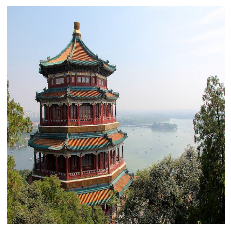

In [12]:
plot_color_image(images_resized[0])

Note it doesn't preserve the aspect ratio.  We can use ```tf.image.crop_and_resize()``` to maintain it

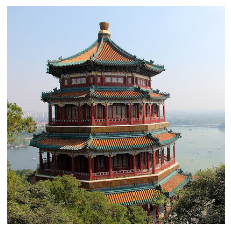

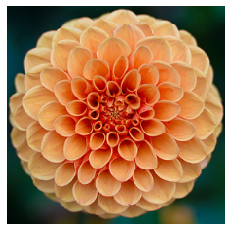

In [13]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

The models assume the input data will be in a certain format, luckily they contain a ```preprocess_input()``` function to help us pre-process them

In [14]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [15]:
y_proba = model.predict(inputs)

In [16]:
y_proba[0, :50]

array([7.35480654e-09, 2.15529603e-08, 7.46987272e-09, 2.31638131e-09,
       7.31778149e-09, 9.32002422e-08, 8.93067664e-08, 1.85589144e-08,
       3.97903399e-09, 4.18401562e-08, 3.93257949e-07, 1.39541172e-07,
       5.75582362e-07, 1.11528642e-07, 1.62498168e-06, 7.77712728e-07,
       3.78676965e-08, 8.67022266e-07, 3.45130957e-07, 3.06080693e-07,
       2.45904261e-07, 8.53849702e-09, 4.16528003e-08, 1.01924726e-07,
       9.11239084e-09, 2.10373363e-09, 5.81227466e-09, 4.55991422e-09,
       1.00956594e-08, 2.58364219e-09, 1.59329474e-08, 1.71128036e-08,
       3.87643730e-08, 6.84298396e-09, 1.56608788e-08, 1.99275654e-08,
       5.70167069e-09, 5.27858735e-09, 5.79084070e-09, 3.85494445e-08,
       7.36563033e-09, 6.15518587e-08, 1.14524279e-09, 1.60870020e-08,
       1.88897964e-08, 8.14267498e-09, 4.83615858e-09, 1.01871379e-07,
       4.59081329e-10, 1.73487713e-08], dtype=float32)

The results for each image is a column vector of probabilities for each class. The models also include a ```decode_predictions``` functions to parse the outputs

In [17]:
top_K = keras.applications.resnet50.decode_predictions(y_proba, top=3)
for image_index in range(len(images)):
    print(f'Image #{image_index}')
    for class_id, name, y_proba in top_K[image_index]:
        print(f" {class_id} - {name:12s} {y_proba*100:.2f}")
    print()

Image #0
 n03877845 - palace       43.39
 n02825657 - bell_cote    43.07
 n03781244 - monastery    11.70

Image #1
 n04522168 - vase         53.96
 n07930864 - cup          9.52
 n11939491 - daisy        4.97



## Pretrained Models for Transfer Learning

If we want to create a classifier but do not have enough training data, we can re-use lower layers of pre-trained models. Let's crete a classifier for flower re using the Xception model

In [21]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

In [20]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [22]:
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

This data only has a training set. Let's split it into train test and validation sets

In [24]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    'tf_flowers',
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised=True)

The CNN expects 224x224 images so we need to resize them as well as running them through Xception's ```preprocess_input``` function

In [25]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Now we apply tem to all datasets

In [27]:
batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

*Note:* The ```keras.preprocessing.image.ImageDataGenerator``` class makes it easy to load images from disk and augment them in various ways: shifting, rotating, rescaling, flipping etc...

We'll finally load the Xception model, pretrained on ImageNet. We will exclude the top of the network by setting ```include_top=False```. This excludes the global average pooling layer and the dense output layer. We'll add our own layers for these

In [28]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 20s 0us/step


We'll freeze the pre-trained layers (so as not to forget the pre-training)

In [29]:
for layer in base_model.layers:
    layer.trainable = False

*Note:* Only train below for two epochs as it takes a while...

In [31]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.6, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set, epochs=2, validation_data=valid_set)

Epoch 1/2
86/86 [==============================] - 293s 3s/step - loss: 0.5421 - accuracy: 0.8078 - val_loss: 0.4099 - val_accuracy: 0.8457
Epoch 2/2
86/86 [==============================] - 283s 3s/step - loss: 0.2344 - accuracy: 0.9161 - val_loss: 0.3785 - val_accuracy: 0.8711


In [32]:
model.evaluate(test_set)

12/12 [==============================] - 30s 3s/step - loss: 0.3518 - accuracy: 0.8910


[0.35176578164100647, 0.891008198261261]

89% accuracy, not bad for only 2 epochs of training. Let's now unfreeze the base layers and train a bit more. We'll also reduce the learning rate to avoid damaging the pretrained weigths

In [33]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set, epochs=2, validation_data=valid_set)

Epoch 1/2
86/86 [==============================] - 1228s 14s/step - loss: 0.3113 - accuracy: 0.8993 - val_loss: 0.3914 - val_accuracy: 0.8639
Epoch 2/2
86/86 [==============================] - 1189s 14s/step - loss: 0.0536 - accuracy: 0.9847 - val_loss: 0.2165 - val_accuracy: 0.9256


In [34]:
model.evaluate(test_set)

12/12 [==============================] - 29s 2s/step - loss: 0.2338 - accuracy: 0.9319


[0.23375250399112701, 0.9318801164627075]

Up to 93% accuracy :) 

## Classifcation and Localization

Another task you might want to do with computer vision, is to identify where an object is. Localizing the object can be expressed as a regression task by predicting a bounding box around the object. A common approach is to predict the horizontal and vertical coordinates of the object's center, height and width. this  means we have 4 numbers to predict.


To adjust we need to add a second dense output layer with four units and train it using MSE loss

In [37]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])

The problem now is that the dataset we're using does not have bounding boxes around the flowers, we'll need to add them ourselves.

Some of the tools we can use to annotate images are listed:
- VGG image annotator
- LabelImg
- OpenLabeler
- ImgLab
- LabelBox (commercial)
- Supervisely (commercial)

Crowdsourcing platforms such as Amazon mechanical Turk are an option if the number of images is very large. Adriana Kovashka et al. wrote a [very practical paper](https://arxiv.org/abs/1611.02145) on crowdsourcing in computer vision, worth a read!

We will suppose we've obtained the bounding boxes in some way. Then we'll need to create a dataset whose items are batches of preprocessed images along with their class labels and bounding boxes. The items will be tuples of the form ```(images, (class_labels, bounding_boxes))```.

**Tip:** bounding boxes should be normalized so that the horizontal and vertical coordinates, as well as the height and width all range from 0 to 1. it is also common to predict the square root of the height and width rather than their values directly. This way a 10-pixel error for a large bounding box will not be penalized as much as a 10-pixel error for a small bounding box

For bounding boxes, the MSE works well to train the model but it is not great to evaluate how well the model can predict them. The most common metric for this is the *Intersection  over Union*; the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union (figure 14-23)

But what if the images contain multiple objects?

## Object Detection

The task of classifying and detecting multiple objects in an image is called *object detection*. A common approached used until recently was to train a CNN to classify and locate a single object then slide it across the image. This process is very well described in page 486

It is however quite slow. A better way to do it is using a *fully convolutional network*

### Fully convolutional networks

Proposed in [2015](https://arxiv.org/abs/1411.4038) for sematinc segmentation, the idea behind FCNs is to replace the dense layers at the top of a CNN by convolutional layers. 

Consider the following example: 
Suppose a dense layer of 200 neurons sits on top of a convolutional layer that outputs 100 feature maps, each of size 7x7. Each neuron will compute a weighted sum of all 100x7x7 activations from the convolutional layer.

If we replace that dense layer with a convolutional layer using 200 filters, each of size 7x7 with 'valid' padding, it will output 200 feature maps os size 1x1. Thus it outputs 200 numbers, just like the dense layer, and upon inspection, the number match the same ones as the dense layer. The difference lies in the shape: the dense layer outputs a tensor of shape [batch_size, 200] while the convolutional layer outputs [batch_size, 1, 1, 200]

This is helpful since, dense layers expece inputs of specific size, however convolutional layers process images of any size. 

For example take a CNN for flower classification and detection, trained on 224x224 images with 10 outputs: 0-4 go through softmax yielding class probabilities, output 5 gives the objectness score and 6-9 represent the bounding box's center coordinates as well as width and height. 

We can convert the dense layers to convolutional layers without even retraining! We can just copy the weights of the convolutional layers. Now this FCN is capable of taking images of any size as an input. Page 488 goes in detail of an example (must read!).

In summary, for an image with double the size, the FCN will be outputting a sliding window where each cell contains 10 outputs with the class probabilities, objectness and bounding boxes

### You Only Look Once ([YOLO](https://arxiv.org/abs/1506.02640))

YOLO is an extremely fast and accurate object detection architecture developed in 2015 and subsequentely improved in [2016](https://arxiv.org/abs/1612.08242) and [2018](https://arxiv.org/abs/1804.02767). It is so fast it can run in [real time](https://www.youtube.com/watch?v=MPU2HistivI).

It's architecture is quite similar to the ones discussed above, with a few important differences:

- It outputs five bounding boxes for each grid cell (instead of just one), each bounding box with an objectness score
- The predictions for the coordenates are offsets relative to the bottom right ((0,0) top left, (1,1) bottom right) , instead of absolute values. It applies the logistic function to the bounding box coordinates to ensure they remain within 0 and 1
- Before training, YOLO finds representative bounding boxes called *anchor boxes*, it does so by  clustering the training images by height and width. Each prediction is a value to rescale the anchor boxes (e.g. 1.5, 0.9, etc..)
- The network is trained on images of different scales, every few batches the network randomly chooses a new image dimension, allowing the network to learn objcts at different scales

 The papers are well worth a read and provide an example of how Deept Learning systems can be incrementally improved. In the 2016 paper, YOLO9000 uses hierarchical classification using a visual hierarchy called *WordTree*. This makes it possible for the network to predict with high confidence that an image represents a, say, dog, even though it doesn't know what kind of dog.

##### A note on mAP
**Mean Average Precision** is a commonly used metric for object detection tasks. Remember from earlier in the text *precision*, *recall* and the associated trade-off between the two (Chapter 3). This is one of the motivations for mAP.

Suppose a classifier has 90% precision at 10% recall and 96% precision at 20% recall. There's no trade-off here, makes sense using the one which maximises both. So instead of looking at the precision at 10% we look for a classifier which can offer *at least* 10% recall. One way to get a better understanding of the model's performance is to get the ptrecision at 0% recall, 10% recall and so on and average these maximum predictions. This is called *Average Precision*. Now when there are multiple classes, we compute the AP for each class and the compute the mAP!

You can find various implementations of YOLO on GitHub. In particular check out [this one].(https://github.com/zzh8829/yolov3-tf2). On TF-Hub we can also find popular models for object detection such as [SSD](https://arxiv.org/abs/1512.02325) and [Faster-RCNN](https://arxiv.org/abs/1506.01497)

## Semantic Segmentation

This is the task of classifying each pixel according to the class of the object it belongs to (e.g. road, car, pedestrian..). Note that different objects of the same class are **not** distinguished, for example multiple bikes in an image can be lumped into one blob. The main challenge is the loss of information in spatial resolution (due to the image passing through layers with strides greater than 1).

One simple approach to tackling this project is to transforming a pre-trained CNN and turning it into an FCN. The CNN applies an overall stride of 32 to the image, i.e. the outputs are 32 times larger than the picture. Then an *upsample layer* is added and multiplies the image resolution by 32. 

To upsample, a *transposed convolutional layer* is used. This is equivalent to stretching the image and inserting empty rows and columns (full of zeros), then performing a regular convolution (img 14-27 pg 493). The transposed convolutional layer can be initialized to perform something like linear interpolation, but since it is a trainable layer, it will learn during training. In tf.keras you can use ```Conv2DTranspose``` layer.

Note: In transposed convolutional layers, the stride defines how much the input will be stretched. The larger the stride, the larger the output

To improve the performance even further, we can add skip connections from lower layers. E.g. instead of upsampling the final output by 32, we can upsample by 2, add output of lower layer (with the appropriate size) then upsample by 16. 

You can also try other variations, such as: upsample 2, add output of lower layer, upsample 2, add output of even lower layer, upsample 8. And other combinations as well. You can even scale up to beyond the size of the original image, this is called *super-resolution*

Note on book about Git Repos, instance segmentation, adversarial networks, image generation and capsule networks. (pg 496)